In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib as plb
import seaborn as sns
from scipy import stats
import statistics
import dabest as db
from skimage.io import imread
from pandas.api.types import CategoricalDtype
from statsmodels.formula.api import ols
from scipy.stats import shapiro, normaltest, kruskal, mannwhitneyu

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### To do:
1. Get a count for total # of biological reps per strain (doesn't include QC). This is to get a measurement of how hard it was to get accurate counts due to clumping
2. Generate code to filter out technical reps (duplicates) for a given screen
3. Generate plots of the current datasets

In [37]:
all_dat = pd.read_csv('C:/Users/Emily/Desktop/DS/Data/DS2/DS2R1_11.csv', index_col=0)
ds_md = pd.read_csv('C:/Users/Emily/Desktop/DS/DS_MD.csv').drop([0])

In [38]:
hf_dat = pd.read_csv('C:/Users/Emily/Desktop/DS/Data/DS2/yak_hen.csv', index_col=0)
hf_md = pd.read_csv('C:/Users/Emily/Desktop/DS/HF/HF_MD.csv', index_col=0)

### Cleaning up the data
Some of the data wasn't entered correctly into the metadata sheet during an assay. Unfortunately the data needs to be removed for the associated plates.

In [39]:

hf_dat = hf_dat.loc[(hf_dat['Compound'] != 'MT:MT') & 
                    (hf_dat['Compound'] != 'H20:DMSO')]
hf_dat['Compound'].unique().tolist()                    

['DI', '2-NO', 'DMSO:DMSO', 'IA', 'MT', '1-Oct', nan]

In [40]:
plates = ['DS2_R1_7', 'DS2_R1_8', 'DS2_R1_9']
all_dat = all_dat[~all_dat['Plate ID'].isin(plates)].dropna()
all_dat = all_dat.loc[all_dat['Strain'] != 'corrupt']
all_dat = all_dat.append(hf_dat)
print(len(all_dat))

314


In [41]:
all_dat = all_dat.dropna().replace({'DMSO_DMSO': 'DMSO:DMSO', '2-NO': '2NO', 
                                   '1-Oct': '1OCT'})


In [45]:
#passed = all_dat.loc[all_dat['Passes QC'] == 'Y']
strains = all_dat['Strain'].unique().tolist()
compounds = all_dat['Compound'].unique().tolist()
compounds

['DI', '2NO', '1OCT', 'DMSO', 'MT', 'IA']

In [43]:
ds_md = ds_md[['Plate ID', 'Compound Well A','Compound Well B', 'Compound Well C', 'Compound Well D', 
              'Strain Well A', 'Strain Well B', 'Strain Well C', 'Strain Well D', 'Image ID', 'Scanner Slot:']]
hf_md = hf_md[['Plate ID', 'Compound Well A','Compound Well B', 'Compound Well C', 'Compound Well D', 
              'Strain Well A', 'Strain Well B', 'Strain Well C', 'Strain Well D', 'Image ID', 'Scanner Slot:']]
all_md = ds_md.append(hf_md)

In [44]:
all_dat = all_dat.replace({'DMSO_DMSO': 'DMSO', '2-NO': '2NO', 
                                   '1-Oct': '1OCT', 'DMSO:DMSO': 'DMSO', 'DMSO_MT':'MT' })

In [46]:
def get_worm_locs_c(row, wrms, result_dict): 

    fname = row['File Name']
    wellnum = row['WellNo']
    loc_fname =  wrms.joinpath('loc_' + fname + '_' + wellnum + '.csv')
    temp = pd.read_csv(loc_fname)
    compound = row['Compound']
    xs = temp['X']

    if compound in result_dict:
        result_dict[compound] = result_dict[compound].append(xs)
        #print(compound + ' ' + str(len(result_dict[compound])))
        result_dict[compound].reset_index(inplace=True, drop=True)
        #print(result_dict.keys())
        
        #result_dict[compound] = result_dict[compound]+xs
    else:
        result_dict[compound]=xs

    return result_dict

def get_worm_locs_s(row, wrms, result_dict): 

    fname = row['File Name']
    wellnum = row['WellNo']
    loc_fname =  wrms.joinpath('loc_' + fname + '_' + wellnum + '.csv')
    temp = pd.read_csv(loc_fname)
    strain = row['Strain']
    xs = temp['X']

    if strain in result_dict:
        result_dict[strain] = result_dict[strain].append(xs)
        #print(compound + ' ' + str(len(result_dict[compound])))
        result_dict[strain].reset_index(inplace=True, drop=True)
        #print(result_dict.keys())
        
        #result_dict[compound] = result_dict[compound]+xs
    else:
        result_dict[strain]=xs

    return result_dict

In [47]:
fpath = plb.Path('C:/Users/Emily/Desktop/DS/Data/DS2/')

In [50]:
c_ordr = ['DMSO', 'MT', 'IA', 'DI', '2NO', '1OCT',]
color_dict = {'DMSO':'#5e4fa2', 'MT':'#5e4fa2', 'IA':'#66c2a5', 'DI':'#66c2a5', '2NO':'#fdae61', '1OCT':'#fdae61'}

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\Program

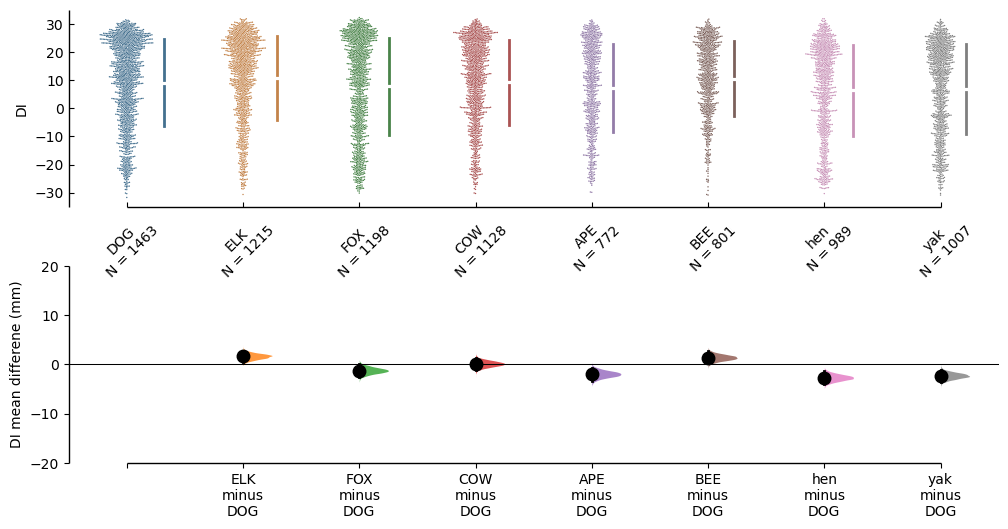

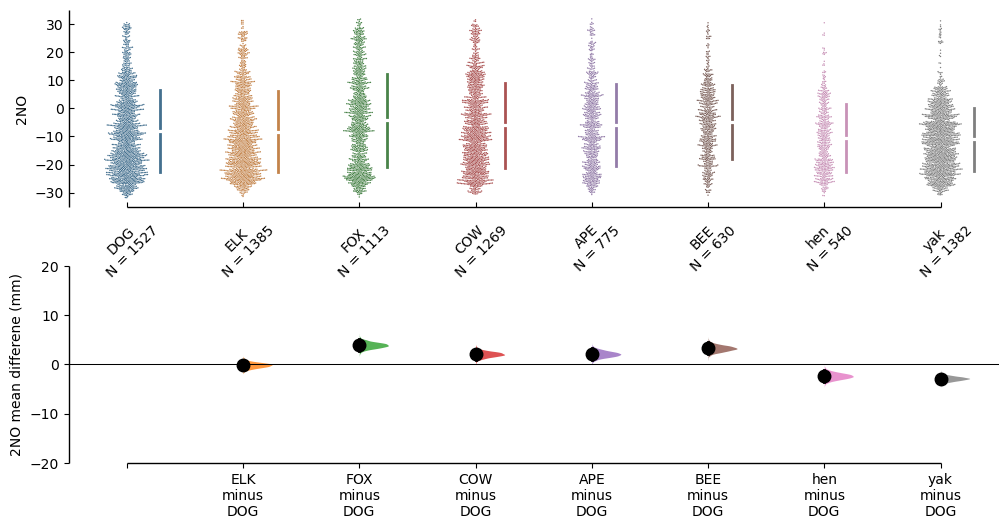

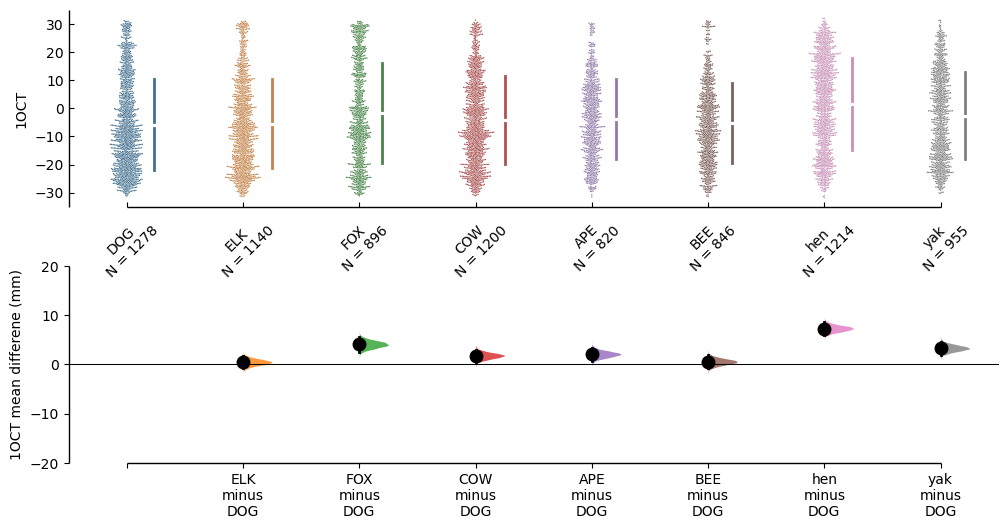

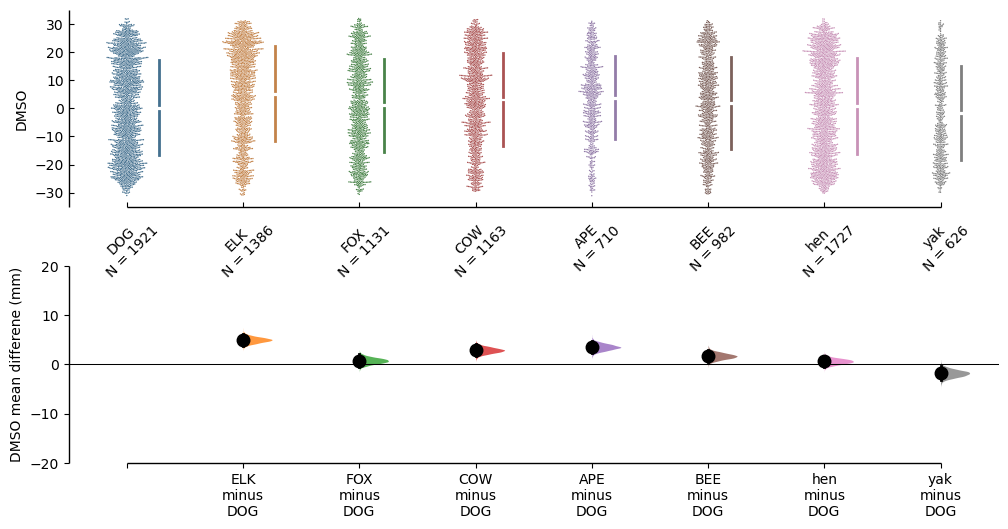

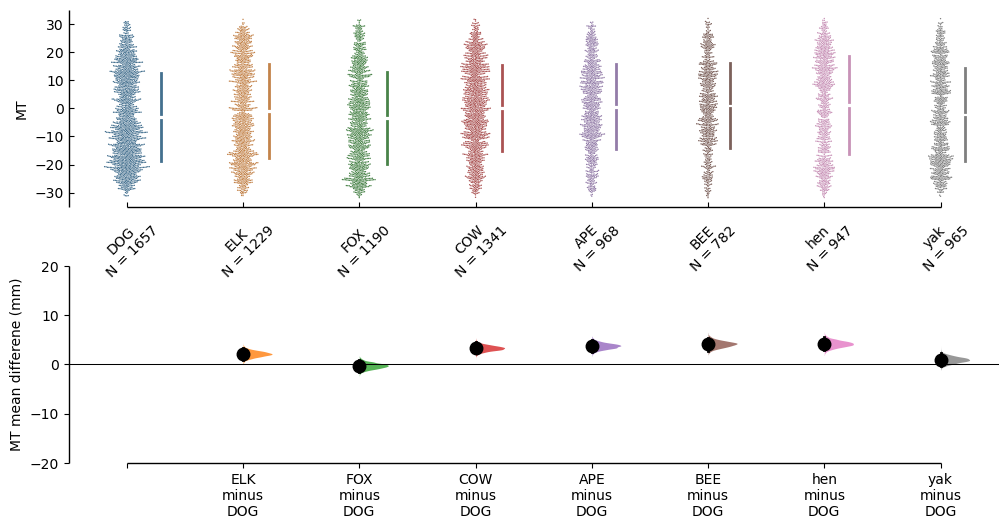

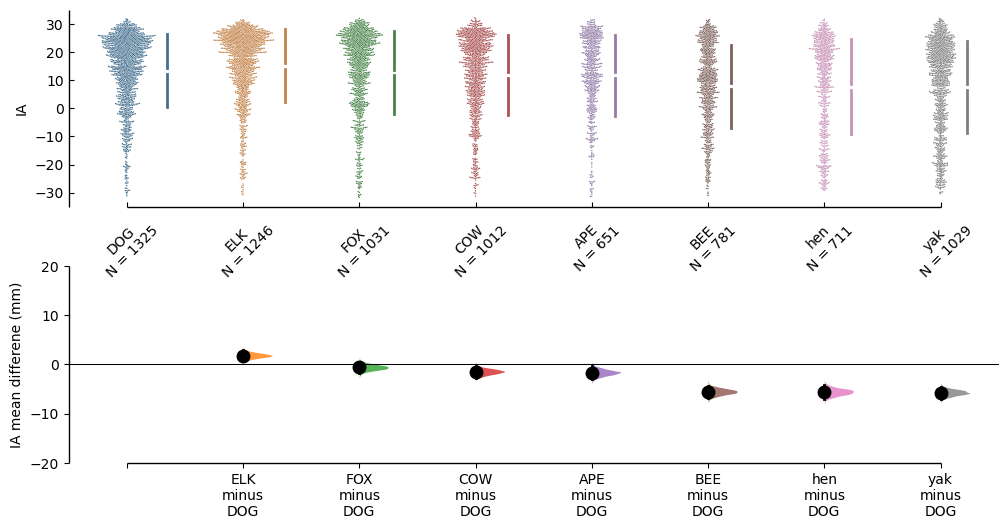

In [54]:
s_ordr = ['DOG', 'ELK', 'FOX', 'COW', 'APE', 'BEE', 'hen', 'yak']
#dog = passed.loc[passed['Strain']=='DOG']
for c in compounds:
    h = {}
    for s in strains:
        data = all_dat.loc[(all_dat['Compound'] == c) & (all_dat['Strain'] == s)]
        for index, row in data.iterrows():
            hold = get_worm_locs_s(row, fpath, h)
        #hold = data.apply(lambda row: get_worm_locs(row, fpath, h), axis=1)
    pooled = pd.DataFrame.from_dict(hold)

    pooled.to_csv('C:/Users/Emily/Desktop/DS/Data/DS2/' + c + '_xs.csv')
    mm = 25.4
    # 1200 pixels per 25.4mm
    px_mm = 1200/mm
    #The following transforms the worm location data so that it is respective to the start zone
    # The start zone is at the center of the image; Start Zone = 0mm
    #Worms with positive values are closer to the compound, negative values are away from the compound
    mm_df = pooled.apply(lambda x: -(x/px_mm)+32.5)
    db_obj = db.load(mm_df, idx=(s_ordr))
    mm_plot = db_obj.mean_diff.plot(raw_marker_size=1, swarm_label = c, 
                                        contrast_label= c + " mean differene (mm)", contrast_ylim = (-20,20), swarm_ylim=(-35,35))

    #Accessing plot axes to control plot asthetics
    rawswarm_axes = mm_plot.axes[0]
    contrast_axes = mm_plot.axes[1]

    rawswarm_axes.yaxis.set_tick_params(tickdir='in')
    rawswarm_axes.xaxis.set_tick_params(tickdir='in', rotation=45)
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig('C:/Users/Emily/Desktop/DS/Figs/' + c + '_N2ref.png')

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\Program

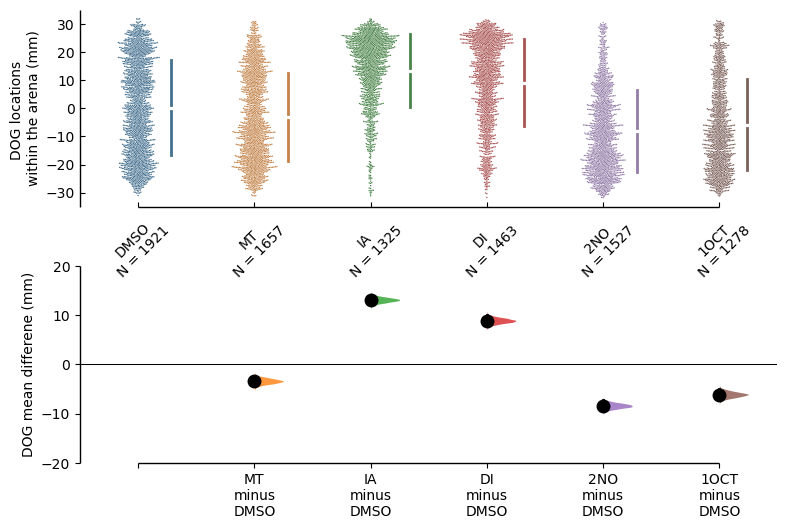

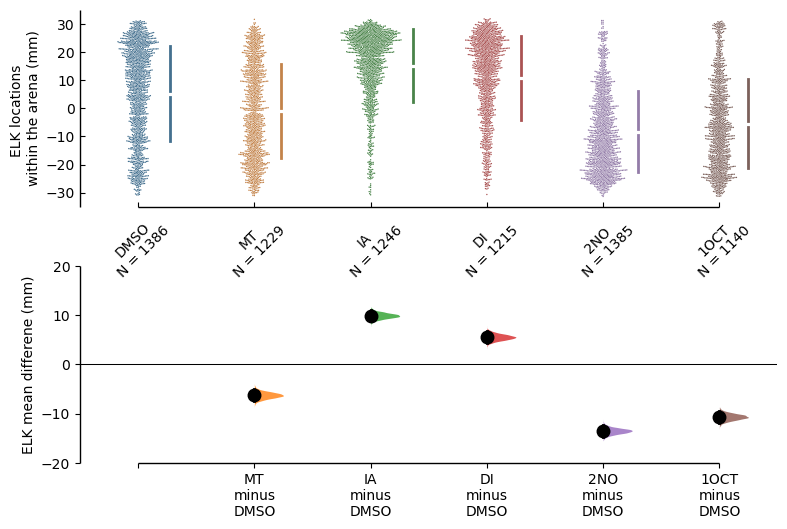

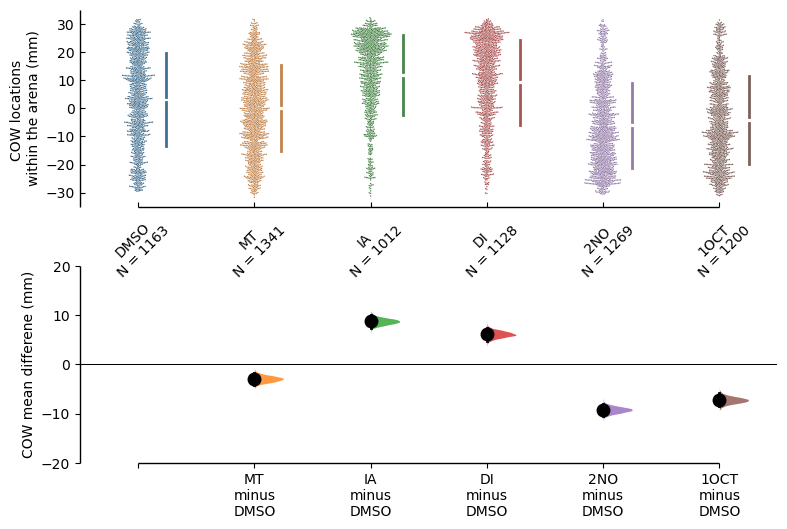

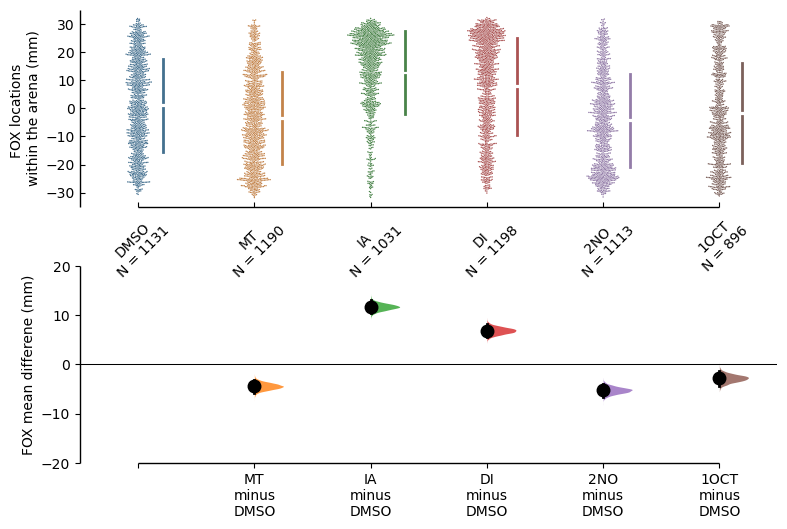

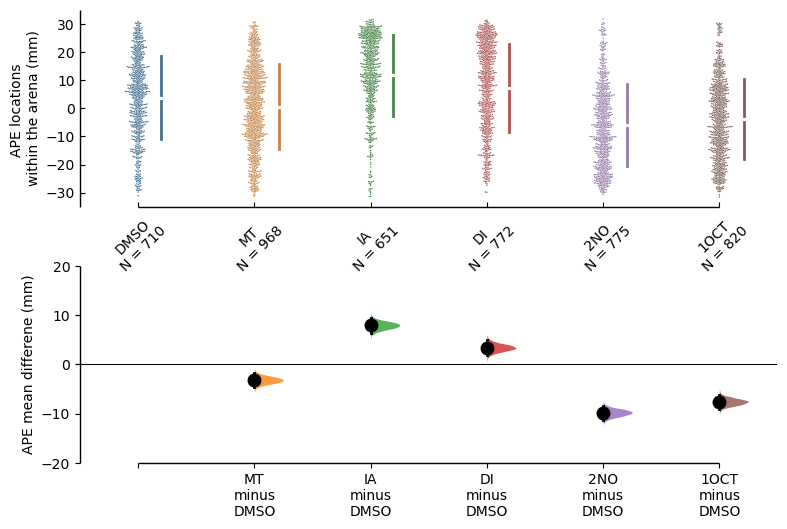

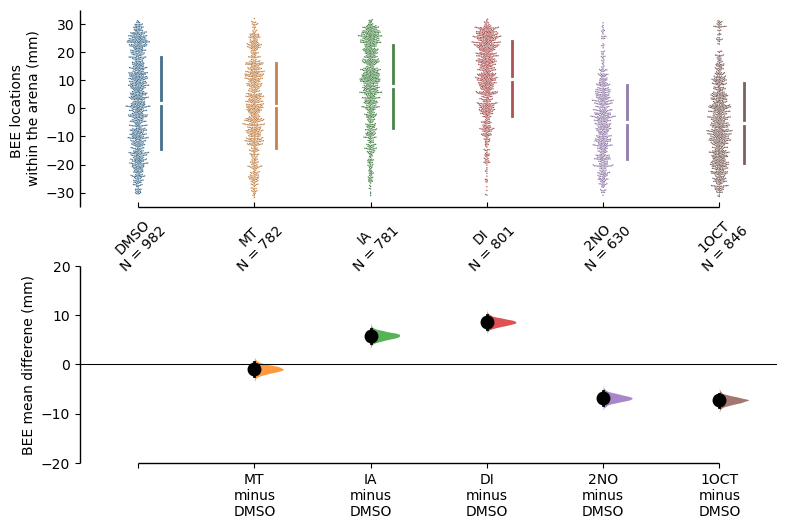

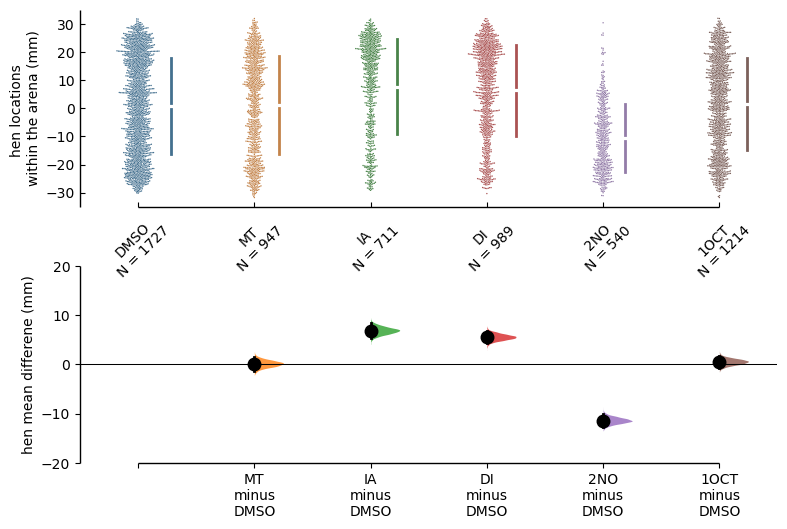

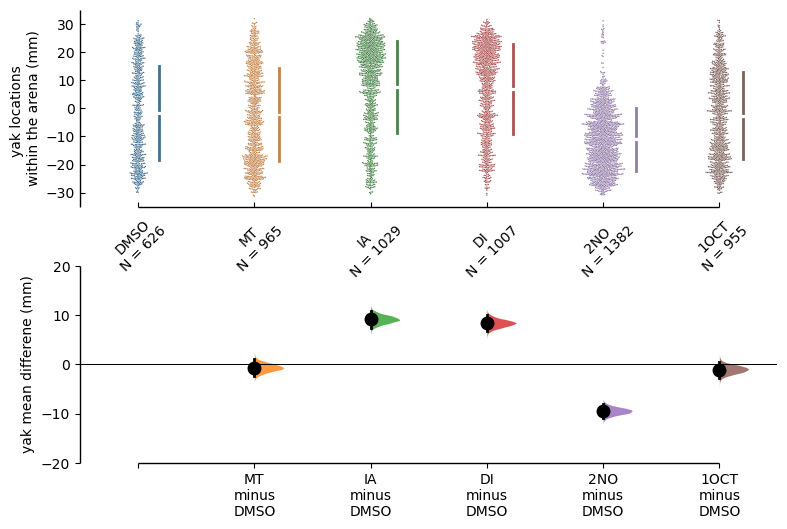

In [55]:

#dog = passed.loc[passed['Strain']=='DOG']
for s in strains:
    h = {}
    for c in compounds:
        data = all_dat.loc[(all_dat['Compound'] == c) & (all_dat['Strain'] == s)]
        for index, row in data.iterrows():
            hold = get_worm_locs_c(row, fpath, h)
        #hold = data.apply(lambda row: get_worm_locs(row, fpath, h), axis=1)
    pooled = pd.DataFrame.from_dict(hold)
    #pooled.to_csv('C:/Users/Emily/Desktop/DS/Data/DS2/' + s + '_xs.csv')
    mm = 25.4
    # 1200 pixels per 25.4mm
    px_mm = 1200/mm
    #The following transforms the worm location data so that it is respective to the start zone
    # The start zone is at the center of the image; Start Zone = 0mm
    #Worms with positive values are closer to the compound, negative values are away from the compound
    mm_df = pooled.apply(lambda x: -(x/px_mm)+32.5)
    db_obj = db.load(mm_df, idx=(c_ordr))
    mm_plot = db_obj.mean_diff.plot(raw_marker_size=1, swarm_label = s + ' locations \nwithin the arena (mm)', 
                                        contrast_label= s + " mean differene (mm)", contrast_ylim = (-20,20), swarm_ylim=(-35,35))

    #Accessing plot axes to control plot asthetics
    rawswarm_axes = mm_plot.axes[0]
    contrast_axes = mm_plot.axes[1]

    rawswarm_axes.yaxis.set_tick_params(tickdir='in')
    rawswarm_axes.xaxis.set_tick_params(tickdir='in', rotation=45)
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig('C:/Users/Emily/Desktop/DS/' + s + '_nullref.png')
    

### Analysis of attempts vs total QC passd for each strain

In [8]:
a = all_dat.groupby(['Compound', 'Strain'])['WellNo'].count().reset_index(name="Total_attempts")

In [9]:
p = a.groupby(['Compound', 'Strain'])['WellNo'].count().reset_index(name='QC_passed')

In [10]:
c = pd.merge(a, p, on=['Compound', 'Strain'], how='inner')
c['Failed'] = c.apply(lambda x: x['Total_attempts'] - x['QC_passed'], axis=1)


In [11]:
c.groupby('Strain').sum()

,Total_attempts,QC_passed,Failed
Strain,,,
APE,23,15,8
BEE,24,16,8
COW,42,21,21
DOG,57,31,26
ELK,58,21,37
FOX,50,18,32
